#1.モデルの準備

In [1]:
!nvidia-smi

Wed Jan  5 10:10:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import random
import os

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow._api.v2 import image

def set_seed(seed=1):
    tf.random.set_seed(seed)
    # optional
    # for numpy.random
    np.random.seed(seed)
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
set_seed(1)

print('TF version:', tf.__version__)
print('Hub version:', hub.__version__)
print('Phsical devices:', tf.config.list_physical_devices())

def get_hub_url_and_isize(model_name, ckpt_type, hub_type):
  if ckpt_type == '1k':
    ckpt_type = ''  # json doesn't support empty string
  else:
    ckpt_type = '-' + ckpt_type  # add '-' as prefix
  
  hub_url_map = {
    'efficientnetv2-b0': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b0/{hub_type}',
    'efficientnetv2-b1': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b1/{hub_type}',
    'efficientnetv2-b2': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b2/{hub_type}',
    'efficientnetv2-b3': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b3/{hub_type}',
    'efficientnetv2-s':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s/{hub_type}',
    'efficientnetv2-m':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m/{hub_type}',
    'efficientnetv2-l':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l/{hub_type}',

    'efficientnetv2-b0-21k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b0-21k/{hub_type}',
    'efficientnetv2-b1-21k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b1-21k/{hub_type}',
    'efficientnetv2-b2-21k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b2-21k/{hub_type}',
    'efficientnetv2-b3-21k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b3-21k/{hub_type}',
    'efficientnetv2-s-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s-21k/{hub_type}',
    'efficientnetv2-m-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m-21k/{hub_type}',
    'efficientnetv2-l-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l-21k/{hub_type}',
    'efficientnetv2-xl-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-xl-21k/{hub_type}',

    'efficientnetv2-b0-21k-ft1k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b0-21k-ft1k/{hub_type}',
    'efficientnetv2-b1-21k-ft1k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b1-21k-ft1k/{hub_type}',
    'efficientnetv2-b2-21k-ft1k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b2-21k-ft1k/{hub_type}',
    'efficientnetv2-b3-21k-ft1k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b3-21k-ft1k/{hub_type}',
    'efficientnetv2-s-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s-21k-ft1k/{hub_type}',
    'efficientnetv2-m-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m-21k-ft1k/{hub_type}',
    'efficientnetv2-l-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l-21k-ft1k/{hub_type}',
    'efficientnetv2-xl-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-xl-21k-ft1k/{hub_type}',
      
    # efficientnetv1
    'efficientnet_b0': f'https://tfhub.dev/tensorflow/efficientnet/b0/{hub_type}/1',
    'efficientnet_b1': f'https://tfhub.dev/tensorflow/efficientnet/b1/{hub_type}/1',
    'efficientnet_b2': f'https://tfhub.dev/tensorflow/efficientnet/b2/{hub_type}/1',
    'efficientnet_b3': f'https://tfhub.dev/tensorflow/efficientnet/b3/{hub_type}/1',
    'efficientnet_b4': f'https://tfhub.dev/tensorflow/efficientnet/b4/{hub_type}/1',
    'efficientnet_b5': f'https://tfhub.dev/tensorflow/efficientnet/b5/{hub_type}/1',
    'efficientnet_b6': f'https://tfhub.dev/tensorflow/efficientnet/b6/{hub_type}/1',
    'efficientnet_b7': f'https://tfhub.dev/tensorflow/efficientnet/b7/{hub_type}/1',
  }
  
  image_size_map = {
    'efficientnetv2-b0': 224,
    'efficientnetv2-b1': 240,
    'efficientnetv2-b2': 260,
    'efficientnetv2-b3': 300,
    'efficientnetv2-s':  384,
    'efficientnetv2-m':  480,
    'efficientnetv2-l':  480,
    'efficientnetv2-xl':  512,
  
    'efficientnet_b0': 224,
    'efficientnet_b1': 240,
    'efficientnet_b2': 260,
    'efficientnet_b3': 300,
    'efficientnet_b4': 380,
    'efficientnet_b5': 456,
    'efficientnet_b6': 528,
    'efficientnet_b7': 600,
  }
  
  hub_url = hub_url_map.get(model_name + ckpt_type)
  image_size = image_size_map.get(model_name, 480)
  return hub_url, image_size


def get_imagenet_labels(filename):
  labels = []
  with open(filename, 'r') as f:
    for line in f:
      labels.append(line.split('\t')[1][:-1])  # split and remove line break.
  return labels


TF version: 2.7.0
Hub version: 0.12.0
Phsical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
# Build model
import tensorflow_hub as hub
model_name = 'efficientnetv2-b0' #@param {type:'string'}
ckpt_type = '21k'   # @param ['21k', '21k-ft1k', '1k']
hub_type = 'feature-vector' # @param ['feature-vector']
batch_size = 32#@param {type:"integer"}
hub_url, image_size = get_hub_url_and_isize(model_name, ckpt_type, hub_type)

#2.データセットの準備

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
out_pattern = 'D' #@param ['A', 'B', 'C', 'D']

In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_dir = "/content/drive/MyDrive/techno_pro/data/train_out/valid_"+out_pattern+"/"
datagen_kwargs = dict(rescale=1./255)
dataflow_kwargs = dict(target_size=(image_size, image_size),
                       batch_size=batch_size,
                       interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization=True,
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=False, class_mode='binary', **dataflow_kwargs)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      samplewise_center = True,
      samplewise_std_normalization=True,
      horizontal_flip=True,
      vertical_flip=True,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
data_dir = "/content/drive/MyDrive/techno_pro/data/train_out/train_"+out_pattern+"/"
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, seed=1, class_mode='binary', **dataflow_kwargs)

Found 1150 images belonging to 2 classes.
Found 3450 images belonging to 2 classes.


#3.モデルの学習(finetuning)

In [26]:
# whether to finetune the whole model or just the top layer.
do_fine_tuning = True #@param {type:"boolean"}
num_epochs = 8 #@param {type:"integer"}

tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=[image_size, image_size, 3]),
    hub.KerasLayer(hub_url, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                          activation='sigmoid')
])
model.build((None, image_size, image_size, 3))
model.summary()

model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss='binary_crossentropy',
  metrics=['accuracy', tf.keras.metrics.AUC()])

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=num_epochs, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              20331360  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 20,332,641
Trainable params: 20,178,769
Non-trainable params: 153,872
_________________________________________________________________
Epoch 1/8


ResourceExhaustedError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


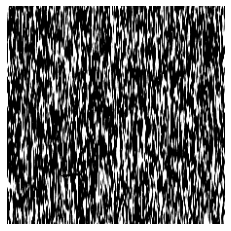

True label: 1.0
Prediction score: 0.99979407


In [ ]:
x, y = next(reversed(valid_generator))
image = x[0, :, :, :]
true_index = y[0]
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_score = model.predict(np.expand_dims(image, axis=0))
print("True label: " + str(true_index))
print("Prediction score: " + str(prediction_score[0][0]))

In [ ]:
import time
t = time.time()
export_path = "./drive/MyDrive/techno_pro/saved_model/{0}_{1}_{2}batch_{3}epoch_{4}".format(int(t), model_name, batch_size, num_epochs, out_pattern)
model.save(export_path, save_format='tf')

INFO:tensorflow:Assets written to: ./drive/MyDrive/techno_pro/saved_model/1641375237_efficientnetv2-b0_32batch_8epoch_B/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/techno_pro/saved_model/1641375237_efficientnetv2-b0_32batch_8epoch_B/assets


In [ ]:
!nvidia-smi

Wed Jan  5 09:34:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    32W / 250W |   4669MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#保存済みモデルのチェック

In [ ]:
reloaded = tf.keras.models.load_model(export_path)

In [ ]:
x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = y[0]
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_score = reloaded.predict(np.expand_dims(image, axis=0))
print("True label: " + str(true_index))
print("Prediction score: " + str(prediction_score[0][0]))